# **Base Ball Project**

In this assignment we will extract the data from a real-life database, wrangle and prepare the data to solve a prediction problem.


# **Step 1**

We will be analyzing Player, Batting, Pitching, Fielding and Salary data tables given and formulate a regression problem that will predict a player's annual salary by looking at their overall stats.

### Importing the necessary libraries


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

### Loading The Data Files

In [ ]:
df_player = pd.read_csv("/content/sample_data/player.csv", usecols=["player_id", "debut", "final_game"], parse_dates=["debut", "final_game"])
df_batting = pd.read_csv("/content/sample_data/batting.csv")
df_pitching = pd.read_csv("/content/sample_data/pitching.csv")
df_fielding = pd.read_csv("/content/sample_data/fielding.csv")
df_salary = pd.read_csv("/content/sample_data/salary.csv")
df_salary.sort_index(inplace=True)

## **Step 2**

In this step we will look into each individual data file and clean it i.e removing all irrelevant material, handling missing values, getting rid of duplicates

### Checking for Duplicates

In [ ]:
print(df_player.duplicated("player_id").sum())
print(df_batting.duplicated("player_id").sum())
print(df_pitching.duplicated("player_id").sum())
print(df_fielding.duplicated("player_id").sum())
print(df_salary.duplicated("player_id").sum())

0
82673
35013
152061
20612


### Duplicates Removal Functions
This function substitutes the most common value in categorical variable columns and subtitutes the numerical variables with there cumulative sum.

In [ ]:
def duplicates(df):
    columns = df.columns
    agg_functions = {}
    for col in columns:
        if df[col].dtype == "object":
            agg_functions[col] = lambda x: x.mode().iloc[0] if not x.mode().empty else None
        elif df[col].dtype in ["float64", "int64"]:
            agg_functions[col] = "sum"

    return df.agg(agg_functions)


### Setting up each individual file

Setting up Batting Data Frame

In [ ]:
df_batting.where(df_batting.values != "", np.nan, inplace=True)
df_batting.drop(columns=["year", "stint"], inplace=True)
df_batting = pd.DataFrame(df_batting.groupby("player_id", group_keys=False).apply(duplicates)) ### Grouping the data frame based on player_id and then applying the duplicates function
df_batting.drop(columns=["player_id"], inplace=True)
df_batting.reset_index(inplace=True)

Setting up Pitching Data Frame

In [ ]:
df_pitching.where(df_pitching.values != "", np.nan, inplace=True)
df_pitching.drop(columns=["year", "stint"], inplace=True)
df_pitching = pd.DataFrame(df_pitching.groupby("player_id", group_keys=False).apply(duplicates))
df_pitching.drop(columns=["player_id"], inplace=True)
df_pitching.reset_index(inplace=True)

Setting up Fielding Data Frame

In [ ]:
df_fielding.where(df_fielding.values != "", np.nan, inplace=True)
df_fielding.drop(columns=["year", "stint"], inplace=True)
df_fielding = pd.DataFrame(df_fielding.groupby("player_id", group_keys=False).apply(duplicates))
df_fielding.drop(columns=["player_id"], inplace=True)
df_fielding.reset_index(inplace=True)

Setting Up Salary Data Frame

This data frame is also grouped by "player_id" and then the variables from the index with maximum salary value are substituted.  

In [ ]:
df_salary_new = pd.DataFrame(df_salary.groupby("player_id", as_index=False).apply(lambda x: x.loc[x['salary'].idxmax()]))
df_salary_new.rename(columns={"team_id": "team_id_salary", "league_id": "league_id_salary"}, inplace=True)
df_salary_new.drop(columns=["year"], inplace=True)

### Merging the Data Frames all together.

This is where we start building our data frame which will later be used for machine learning

In [ ]:
df_batting = pd.merge(left=df_salary_new, right=df_batting, how="left", on="player_id")
df_pitching = pd.merge(left=df_salary_new, right=df_pitching, how="left", on="player_id")
df_fielding = pd.merge(left=df_salary_new, right=df_fielding, how="left", on="player_id")
merged_df = pd.concat([df_batting, df_pitching, df_fielding], axis=0, join="outer", verify_integrity=False)
merged_df = pd.DataFrame(merged_df.groupby(by="player_id", group_keys=True).apply(duplicates))
merged_df.drop(columns=["player_id"], inplace=True)
merged_df.reset_index(inplace=True)
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4963 entries, 0 to 4962
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   player_id         4963 non-null   object 
 1   team_id_salary    4963 non-null   object 
 2   league_id_salary  4963 non-null   object 
 3   salary            4963 non-null   int64  
 4   team_id           4958 non-null   object 
 5   league_id         4958 non-null   object 
 6   g                 4963 non-null   float64
 7   ab                4963 non-null   float64
 8   r                 4963 non-null   float64
 9   h                 4963 non-null   float64
 10  double            4963 non-null   float64
 11  triple            4963 non-null   float64
 12  hr                4963 non-null   float64
 13  rbi               4963 non-null   float64
 14  sb                4963 non-null   float64
 15  cs                4963 non-null   float64
 16  bb                4963 non-null   float64


In [ ]:
merged_df = pd.merge(left=merged_df, right=df_player, how="left", on="player_id")
merged_df.drop(columns=["player_id"], inplace=True)
merged_df.reset_index(inplace=True)

### Feature Engineering
We are going to create 4 extra features from the original dataset and check whether they have strong correlation with our target dataset

In [ ]:
merged_df.drop(columns=["team_id", "league_id"], inplace=True)
merged_df["STRP"] = (merged_df["so"] / merged_df["ab"]) * 100
merged_df["K%"] = merged_df["so"] / merged_df["bfp"]
merged_df["BA"] = merged_df["h"] / merged_df['ab']
merged_df["Days Played"] = (merged_df["final_game"] - merged_df["debut"]).dt.days

## **Step 3**

So far we have cleaned our individual data frames and have merged the together. In this step we will analyze this merged data frame and see how we can further clense our dataset in order to acquire best possible results.

### Using Data Visualization to anaylyze the features

First We will look in to the correlation between Salary (Our Output Variable) and other features

In [ ]:
numeric_df = merged_df.select_dtypes(include=[np.number])
correlation = numeric_df.corr().sort_values(by="salary", ascending=False)
print(correlation["salary"])

salary         1.000000
so             0.654157
hr             0.651796
hbp            0.612577
r              0.612216
sf             0.604545
h              0.593970
bb             0.574899
g              0.482035
rbi            0.462545
double         0.458439
Days Played    0.448105
ibb            0.442765
g_idp          0.427422
ab             0.424463
sh             0.397116
inn_outs       0.360194
w              0.337808
po             0.318422
ipouts         0.313879
bfp            0.310883
er             0.301382
e              0.297382
l              0.293780
triple         0.290056
dp             0.280229
a              0.245145
sb             0.180110
sho            0.176358
baopp          0.171847
sv             0.139812
bk             0.138185
cs             0.137855
gs             0.133904
wp             0.133572
cg             0.117548
era            0.112586
gf             0.092997
K%             0.090798
pb             0.045669
STRP           0.041843
index          0

Now as per the results of correlation we will treat outliers only from features which have a correlation greater than or equal to 0.4 with salary

<ipython-input-14-4e96799ed7f8>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette="viridis")
<ipython-input-14-4e96799ed7f8>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette="viridis")
<ipython-input-14-4e96799ed7f8>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette="viridis")


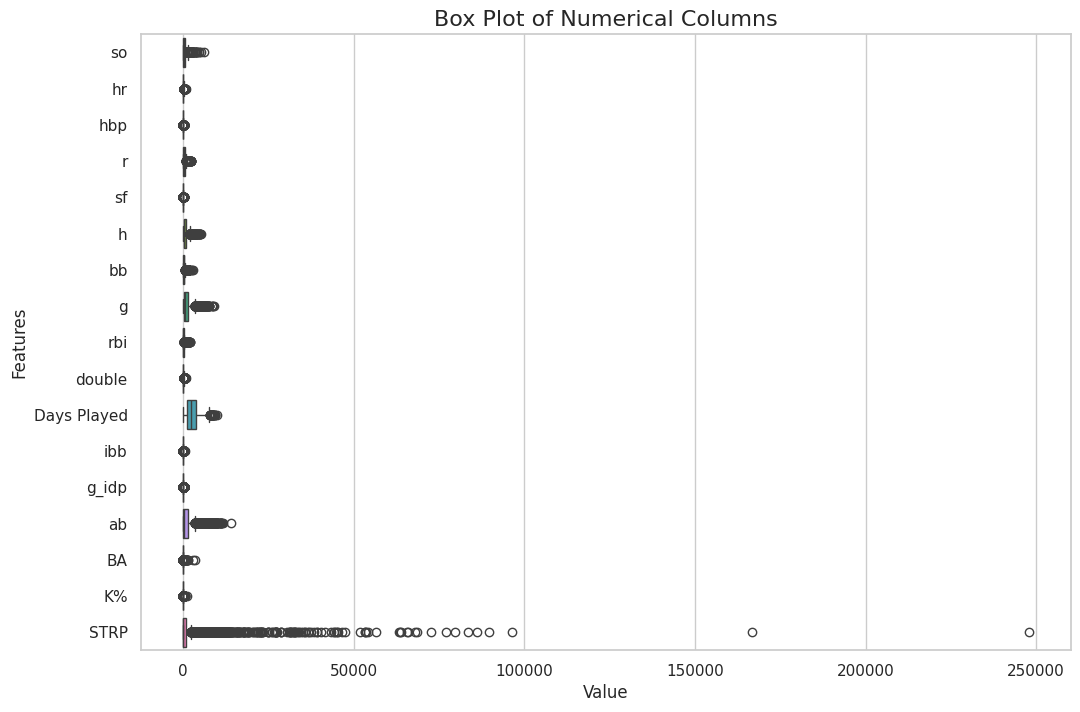

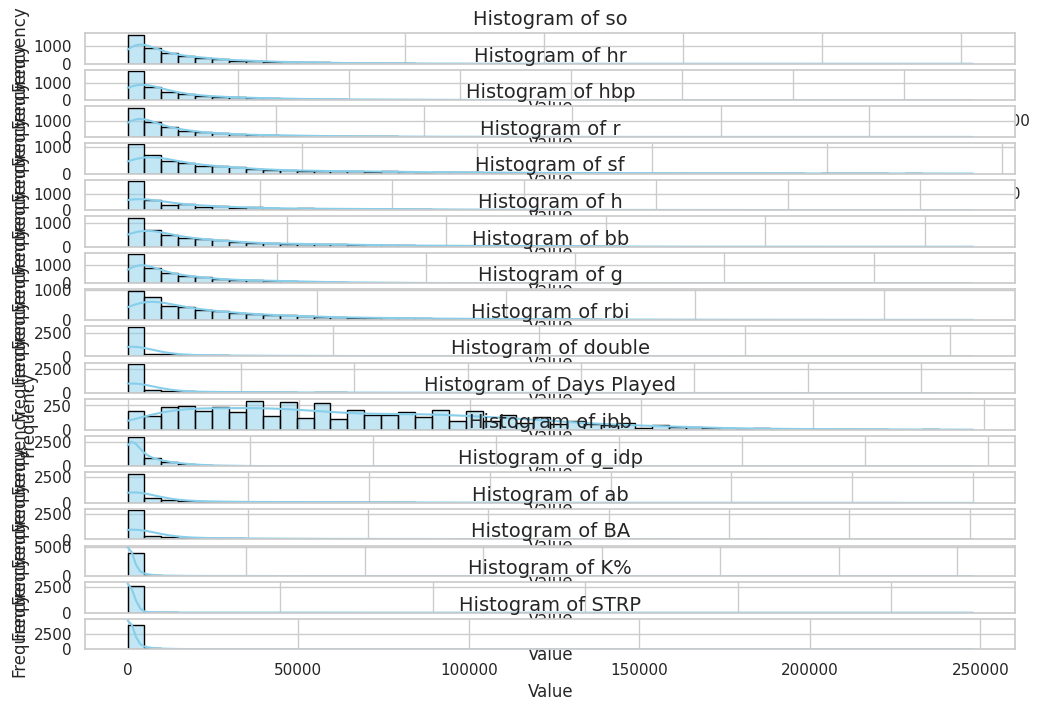

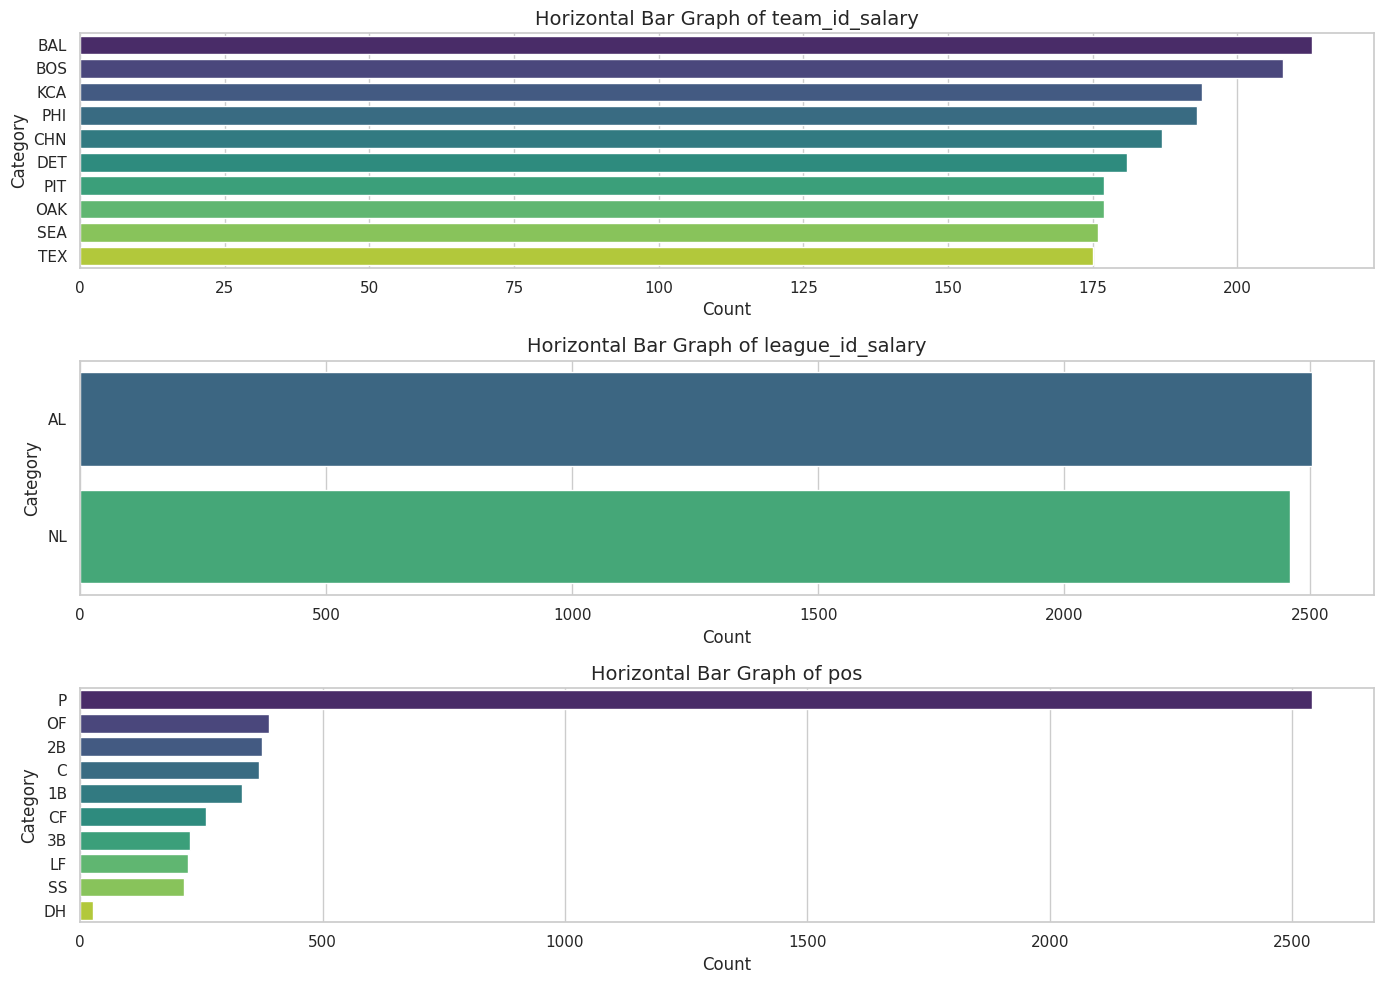

In [ ]:
plot_columns = ['so','hr','hbp','r','sf','h','bb','g','rbi','double','Days Played','ibb','g_idp','ab', 'BA', 'K%', 'STRP'] # Numerical Columns

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.boxplot(data=merged_df[plot_columns], orient="h")
plt.title("Box Plot of Numerical Columns", fontsize=16)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.figure(figsize=(12,8))
for i, col in enumerate(plot_columns):
    plt.subplot(len(plot_columns), 1, i + 1)
    sns.histplot(merged_df[col], bins=50, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {col}', fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

plot_categorical_columns = ['team_id_salary', 'league_id_salary', 'pos'] # Categorical Columns
plt.figure(figsize=(14, 10))

for i, col in enumerate(plot_categorical_columns):
    plt.subplot(len(plot_categorical_columns), 1, i + 1)
    value_counts = merged_df[col].value_counts().head(10)
    sns.barplot(x=value_counts.values, y=value_counts.index, palette="viridis")
    plt.title(f'Horizontal Bar Graph of {col}', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Category', fontsize=12)


plt.tight_layout()
plt.show()
plt.close()

As we can see from histogram that the featurer distribution is left skewed. Hence we use the following method for outliers
We are capping outliers only from the features with correlation greater than or equal to 0.4

In [ ]:
Outlier_dict = {}
for col in plot_columns:
    q25 = merged_df[col].quantile(0.25)
    q75 = merged_df[col].quantile(0.75)
    iqr = q75 - q25
    lower = q25 - iqr * 1.5
    upper = q75 + iqr * 1.5
    count = len(merged_df[merged_df[col] > upper]) + len(merged_df[merged_df[col] < lower])
    Outlier_dict[col] = count
    merged_df[col] = np.where(merged_df[col] > upper, upper, np.where(merged_df[col] < lower, lower, merged_df[col]))

print(Outlier_dict)

{'so': 280, 'hr': 416, 'hbp': 373, 'r': 338, 'sf': 411, 'h': 337, 'bb': 329, 'g': 343, 'rbi': 714, 'double': 705, 'Days Played': 31, 'ibb': 337, 'g_idp': 665, 'ab': 630, 'BA': 857, 'K%': 0, 'STRP': 873}


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


 Now we shall proceed with Data Normalization without remiving these outliers

We have created 4 extra features but none of them, except "Days Played" seems to have a strong correlation with our output variable and also have outliers hence it is inappropriate to use these features for training.

As can be seen from bar graph that the feature pos only has only one significant value therefore we shall drop it also


The player_id column shall also be dropped as there is no use of it onwards

Hence, Dropping all unnecessary columns

In [ ]:
merged_df.drop(columns=['K%', 'BA', 'STRP', "debut", "final_game", "pos", 'pb', 'zr', 'cg', 'sho'], inplace=True)
print(merged_df.info())
print(merged_df.head())
merged_df.to_csv("cleaned_df.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4963 entries, 0 to 4962
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4963 non-null   int64  
 1   team_id_salary    4963 non-null   object 
 2   league_id_salary  4963 non-null   object 
 3   salary            4963 non-null   int64  
 4   g                 4963 non-null   float64
 5   ab                4963 non-null   float64
 6   r                 4963 non-null   float64
 7   h                 4963 non-null   float64
 8   double            4963 non-null   float64
 9   triple            4963 non-null   float64
 10  hr                4963 non-null   float64
 11  rbi               4963 non-null   float64
 12  sb                4963 non-null   float64
 13  cs                4963 non-null   float64
 14  bb                4963 non-null   float64
 15  so                4963 non-null   float64
 16  ibb               4963 non-null   float64


Please note that the csv file "Cleaned_df" created from merged_df is our final data frame and further on we will use this data frame for solving the problem

### Checking For Missing Values

In [ ]:
print(merged_df.isna().sum())

### There are only 5 missing values in our final data frame. Hence we will simply remove them
merged_df.dropna(inplace=True)

index               0
team_id_salary      0
league_id_salary    0
salary              0
g                   0
ab                  0
r                   0
h                   0
double              0
triple              0
hr                  0
rbi                 0
sb                  0
cs                  0
bb                  0
so                  0
ibb                 0
hbp                 0
sh                  0
sf                  0
g_idp               0
w                   0
l                   0
gs                  0
sv                  0
ipouts              0
er                  0
baopp               0
era                 0
wp                  0
bk                  0
bfp                 0
gf                  0
inn_outs            0
po                  0
a                   0
e                   0
dp                  0
Days Played         5
dtype: int64


## **Step 4**

This is the step where we start building our Machine Learning Model. All the working shall be on "Cleaned_df.csv" file as it is our final cleaned data frame.

### Splitting the data into train and test sets

In [ ]:
train = merged_df.copy().drop(columns=["salary", "index"])
print(train.info())
test = merged_df["salary"]
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=72)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(X_train.shape)
print(X_train[0:2])

<class 'pandas.core.frame.DataFrame'>
Index: 4958 entries, 0 to 4962
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   team_id_salary    4958 non-null   object 
 1   league_id_salary  4958 non-null   object 
 2   g                 4958 non-null   float64
 3   ab                4958 non-null   float64
 4   r                 4958 non-null   float64
 5   h                 4958 non-null   float64
 6   double            4958 non-null   float64
 7   triple            4958 non-null   float64
 8   hr                4958 non-null   float64
 9   rbi               4958 non-null   float64
 10  sb                4958 non-null   float64
 11  cs                4958 non-null   float64
 12  bb                4958 non-null   float64
 13  so                4958 non-null   float64
 14  ibb               4958 non-null   float64
 15  hbp               4958 non-null   float64
 16  sh                4958 non-null   float64
 17  

### Data Normalization

In the following lines of code we are rescaling our data set in order to normalize all the features with the similar range. Also we are going to hot encode our categorical data columns

In [ ]:
OHE = OneHotEncoder()
Scaler = MinMaxScaler()
cl_trans = ColumnTransformer(remainder='passthrough', transformers=[
    ("One Hot Encoding", OHE, [0, 1]),
    ("Scaler", Scaler, list(range(2, X_train.shape[1])))
])

### Building multiple Regressor Models

In [ ]:
KNN_r = KNeighborsRegressor()
Tree_r = DecisionTreeRegressor(random_state=72)
RF_r = RandomForestRegressor(random_state=72)

models_dict = {
    'KNN Regressor':{
        'model': KNN_r,
        'params': {'n_neighbors': [3, 5, 7, 9, 11]}
    },
    'Decision Tree':{
        'model': Tree_r,
        'params':{'max_depth': [3, 5, 7, 9, 10]}
    },
    'Random Forest':{
        'model': RF_r,
        'params':{'max_depth': [3, 5, 7, 9, 10], 'n_estimators': [23, 40]}
    }
}

### Applying Grid Search CV to find out the best model for our data set

The above created "models_dict" dictionary is to be used in GridSearchCV.
We will store the results from GridSearchCV in a "scores_dict" dictionary in order to view the results

In [ ]:
X_train_transformed = cl_trans.fit_transform(X_train)
Scores_dict = []
for model_name, model in models_dict.items():
    Reg = GridSearchCV(estimator=model['model'], param_grid=model['params'], cv=5)
    Reg.fit(X_train_transformed, y_train)
    Scores_dict.append({
        'model': model_name,
        'best score': Reg.best_score_,
        'best parameters': Reg.best_params_
    })
Scores_df = pd.DataFrame(Scores_dict, columns=['model', 'best score', 'best parameters', 'best_estimator']).sort_values(by="best score", ascending=False)
print(Scores_df)

           model  best score                        best parameters  \
2  Random Forest    0.778416  {'max_depth': 10, 'n_estimators': 40}   
1  Decision Tree    0.657715                       {'max_depth': 5}   
0  KNN Regressor    0.513508                     {'n_neighbors': 7}   

   best_estimator  
2             NaN  
1             NaN  
0             NaN  


Now we will use the estimator which our GridSearchCV has shown to be the best.
We are goinog to build a pipeline for convenience.

In [40]:
Final_Model = RandomForestRegressor(max_depth=10, n_estimators=40, random_state=72)
print(Final_Model)
Model_Pipeline = Pipeline([
    ("Column Transformer", cl_trans),
    ("Regressor", Final_Model)
]
)
Model_Pipeline.fit(X_train, y_train)
y_pred = Model_Pipeline.predict(X_test)
Accuracy = mean_absolute_error(y_test, y_pred)
print(Accuracy)

RandomForestRegressor(max_depth=10, n_estimators=40, random_state=72)
2582808.6710273814


### Building a Naive Basline Model

In [41]:
class NaiveBaselineRegressor:

    def fit(self, X, y):
        self.mean = np.mean(y)

    def predict(self, X):
        result = np.full(shape=(X.shape[0],), fill_value=self.mean)
        return result


Naive_B = NaiveBaselineRegressor()
Naive_B.fit(X_train, y_train)
y_pred_Naive_B = Naive_B.predict(X_test)
Accuracy_Naive_B = mean_absolute_error(y_test, y_pred_Naive_B)
print(Accuracy_Naive_B)

7397350.463302486


In [10]:
Ridge_Regressor = Ridge(max_iter=10000)
Ridge_Model = GridSearchCV(estimator=Ridge_Regressor, param_grid={'alpha': [0.1, 1, 10]}, cv=5, scoring='mean_absolute_error')
Ridge_Model.fit(X_train_transformed, y_train)
print('Best params: ', Ridge_Model.best_params_)
print('Accuracy: ', Ridge_Model.best_score_)

NameError: name 'X_train_transformed' is not defined